In [1]:
#!/usr/bin/env python
# coding: utf-8

# ___
#
# <a href='http://www.pieriandata.com'> <img src='../Pierian_Data_Logo.png' /></a>
# ___
# # Logistic Regression with Python
#
# For this lecture we will be working with the [Titanic Data Set from Kaggle](https://www.kaggle.com/c/titanic). This is a very famous data set and very often is a student's first step in machine learning!
#
# We'll be trying to predict a classification- survival or deceased.
# Let's begin our understanding of implementing Logistic Regression in Python for classification.
#
# We'll use a "semi-cleaned" version of the titanic data set, if you use the data set hosted directly on Kaggle, you may need to do some additional cleaning not shown in this lecture notebook.
#
# ## Import Libraries
# Let's import some libraries to get started!

# In[1]:


import pandas as pd
import numpy as np
import datetime
import math
import re
import os
import multiprocessing
import sys
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import seaborn as sns

#validates the date
def validate(date_text):
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
        return True
    except ValueError:
        return False

# output: pandas dataframe
def readfile_noh(filename):
    #performing task 1
    trash_offset = 25
    trash_index = 0
    train = pd.read_csv(filename, skiprows= range(0,7), dtype = str)
    train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
    nrows = train.shape[0]
    #print(nrows)
    for x in range(nrows-trash_offset,nrows):
         if type(train.loc[x]['TMAX']) != str:
            trash_index = x
            break
    train.drop(range(trash_index,nrows), inplace = True)

    # performing task 2
    # check if the date data is in the right form
    date_pattern = re.compile(r'\d\d\d\d-\d\d-\d\d')
    searchObj = re.search(date_pattern, train['Date'][0])
    if not searchObj:
        nrows = train.shape[0]
        for x in range(0,nrows):
            train.at[x,'Date'] = datetime.datetime.strptime(train.at[x,'Date'], "%m/%d/%Y").strftime("%Y-%m-%d")


    return train

#train_1958

# this function reads a csv file and process it by
# 1. removing the trash
# 2. get date into the same format
# 3. get time into the same format
# 4. fix the wind speed (change into string)
# input: filename str ---eg.'2011-2018ord.csv'
# output: pandas dataframe
def readfile_ord(filename):

    # performing task 1
    trash_offset = 25
    trash_index = 0
    train = pd.read_csv(filename, skiprows= range(0,8), dtype = {'Temp ('+'F)':str, 'Dewpt ('+'F)':str, 'Wind Spd ('+'mph)':str, 'Wind Direction ('+'deg)':str, 'Peak Wind Gust('+'mph)':str, 'Atm Press ('+'hPa)':str, 'Sea Lev Press ('+'hPa)':str, 'Precip ('+'in)':str}  )
    train = train.loc[:, ~train.columns.str.contains('^Unnamed')]
    nrows = train.shape[0]
    #print(nrows)
    for x in range(nrows-trash_offset,nrows):
        if type(train.loc[x]['Time']) != str:
            trash_index = x
            break
    train.drop(range(trash_index,nrows), inplace = True)

    # performing task 2
    # check if the date data is in the right form
    date_pattern = re.compile(r'\d\d\d\d-\d\d-\d\d')
    searchObj = re.search(date_pattern, train['Date'][0])
    if not searchObj:
        nrows = train.shape[0]
        for x in range(0,nrows):
            train.at[x,'Date'] = datetime.datetime.strptime(train.at[x,'Date'], "%m/%d/%Y").strftime("%Y-%m-%d")

    # performing task 3
    # check if time data is in the right form
    time_pattern = re.compile(r'^\d:\d\d')
    searchObj = re.search(time_pattern, train['Time'][0])
    if searchObj:
        nrows = train.shape[0]
        for x in range(0,nrows):
            # task 3
            searchObj = re.search(time_pattern, train['Time'][x])
            if searchObj:
                train.at[x,'Time'] = '0' + train.at[x,'Time']

    # performing task 4
    train = train.astype({train.columns[4]:'str'})

    return train


# In[ ]:


# this function takes in a date and calculate the mean min max for the features
# input: date -- string in the form of 'yyyy-mm-dd' eg:'1958-11-01'
#        train -- the main datafram to analyze
# output-- list containing:
#        mean_result -- datafram for mean of this feature
#        min_result -- datafram of min of this feature
#        max_result -- datafram of max of this feature
#        invalid_feature
def analyze_by_day(date, train):
    #initialize
    mean_result = float('nan')
    min_result = float('nan')
    max_result = float('nan')
    invalid_feature = 0
    #readin feature data

    train_found = train[train['Date'] == date]

    #print(train_found)

    #train_found.shape[0]
    # calculate how many 'm' there are for each feature out of 24 days
    m_count = 0
    for x in range(0, train_found.shape[0]):
            # count the number of 'm'
        if train_found.iloc[x,2].lower() == 'm':
            m_count += 1
    # if there are total of 6 or more 'm' make this feature invalid
    if m_count >= 6:
        invalid_feature = 1

    #print(invalid_feature)
    if invalid_feature != 1:
        # now we caculate the info from this legit feature
        df2 = train_found.drop(columns =['Date','Time'])
        df1 = df2.apply(pd.to_numeric, errors='coerce')
        df1.fillna(value=df1.mean(), inplace = True)

        mean_result = df1.mean()[0]
        min_result = df1.min()[0]
        max_result = df1.max()[0]



    return mean_result,min_result,max_result,invalid_feature

# this function takes in a date and calculate the mean min max for the features
# input: date -- string in the form of 'yyyy-mm-dd' eg:'1958-11-01'
#        train -- the main datafram to analyze
# output-- list containing:
#        sum_result -- datafram for sum of each day
#        invalid_feature
def analyze_by_day_precip(date, train):
    #initialize
    sum_result = float('nan')
    min_result = float('nan')
    max_result = float('nan')
    invalid_feature = 0
    #readin feature data

    train_found = train[train['Date'] == date]

    #print(train_found)

    #train_found.shape[0]
    # calculate how many 'm' there are for each feature out of 24 days
    m_count = 0
    for x in range(0, train_found.shape[0]):
            # count the number of 'm'
        if train_found.iloc[x,2].lower() == 'm':
            m_count += 1
    # if there are total of 6 or more 'm' make this feature invalid
    if m_count >= 6:
        invalid_feature = 1

    #print(invalid_feature)
    if invalid_feature != 1:
        # now we caculate the info from this legit feature
        df2 = train_found.drop(columns =['Date','Time'])
        df1 = df2.apply(pd.to_numeric, errors='coerce')
        df1.fillna(value=0, inplace = True)

        sum_result = df1.sum()[0]

    return sum_result,min_result,max_result,invalid_feature


def analyze_by_feature_1(feature):
    mean_temp = []
    min_temp =[]
    max_temp = []
    invalid_temp = []
    train_feature = pd.read_csv(feature+'.csv', dtype = str)


    train_index = pd.unique(train_feature['Date'])
    train_index = list(train_index)
    #print(train_index)
    for i in range(len(train_index)):
        #print(feature)
        #print(train_index[i])
        temp = analyze_by_day(train_index[i], train_feature)

        mean_temp.append(temp[0])
        min_temp.append(temp[1])
        max_temp.append(temp[2])
        invalid_temp.append(temp[3])

        '''
        print('this is the ')
        print(i)
        print('\n')
        print(mean_temp)
        print('\n')
        print(min_temp)
        print('\n')
        print(max_temp)
        print('\n')
        print(invalid_temp)
        '''
    # group them together


    mean_df = pd.DataFrame(mean_temp)
    min_df = pd.DataFrame(min_temp)
    max_df = pd.DataFrame(max_temp)
    invalid_df = pd.DataFrame(invalid_temp)


    # calculate mean and other stuff
    mean_df.fillna(value=mean_df.mean(), inplace = True)
    min_df.fillna(value=min_df.mean(), inplace = True)
    max_df.fillna(value=mean_df.mean(), inplace = True)

    mean_final = mean_df.mean()
    min_final = min_df.min()
    max_final = max_df.max()
    invalid_final = invalid_df.sum()




    return mean_final[0],min_final[0],max_final[0],invalid_final[0]

"""
takes the feature, read the data from feature.csv, for each day, calculate the daily mean/max/min and invalid days

"""
def analyze_by_feature_2(feature):

    print('im here')
    sum_temp = []
    mean_temp = []
    min_temp =[]
    max_temp = []
    invalid_temp = []
    train_feature = pd.read_csv(feature+'.csv', dtype = str)


    train_index = pd.unique(train_feature['Date'])
    train_index = list(train_index)
    #print(train_index)
    if feature == 'precip':

        #if current feature is precip, calculate the sum for each day and invalid
        for i in range(len(train_index)):
            #print(feature)
            #print(train_index[i])
            temp = analyze_by_day_precip(train_index[i], train_feature)

            sum_temp.append(temp[0])
            min_temp.append(temp[1])
            max_temp.append(temp[2])
            invalid_temp.append(temp[3])

        #group these days together
        train_df = pd.DataFrame(train_index)
        sum_df = pd.DataFrame(sum_temp)
        min_df = pd.DataFrame(min_temp)
        max_df = pd.DataFrame(max_temp)
        invalid_df = pd.DataFrame(invalid_temp)

        #write the feature out into another file
        temp_write = pd.concat([train_df,max_df,min_df,sum_df],axis = 1)
        temp_write.columns = ['Date','max','min','sum']
        temp_write.to_csv(feature+'_test.csv',index = False, na_rep = float('nan'))
        return

    else:
        # for other features, do the same except get max/min/mean
        for i in range(len(train_index)):
            #print(feature)
            #print(train_index[i])
            temp = analyze_by_day(train_index[i], train_feature)

            mean_temp.append(temp[0])
            min_temp.append(temp[1])
            max_temp.append(temp[2])
            invalid_temp.append(temp[3])

            '''
            print('this is the ')
            print(i)
            print('\n')
            print(mean_temp)
            print('\n')
            print(min_temp)
            print('\n')
            print(max_temp)
            print('\n')
            print(invalid_temp)
            '''
        # group them together
        train_df = pd.DataFrame(train_index)
        mean_df = pd.DataFrame(mean_temp)
        min_df = pd.DataFrame(min_temp)
        max_df = pd.DataFrame(max_temp)
        invalid_df = pd.DataFrame(invalid_temp)


        #write the feature out into another file
        temp_write = pd.concat([train_df,max_df,min_df,mean_df],axis = 1)
        temp_write.columns = ['Date','max','min','mean']
        temp_write.to_csv(feature+'_test.csv',index = False, na_rep = float('nan'))
        return

In [26]:
# multiprocessing.freeze_support()
flag = input('Please input what you want to do( 1 for outputting a range and 2 for outputting daily result)')
path = input('Please type in the path of your data folder:')
# read all the csv files
file_selection = ''
while 1==1:
    file_selection = input('Please input the location of data you want to select '+ '(ugn, ord, or noh'+'):')

    if file_selection == 'ugn' or file_selection == 'ord' or file_selection == 'noh':
        break
listOfFiles = os.listdir(path)

file_pattern_ord = re.compile(r'\d\d\d\dord.csv')
file_pattern_ugn = re.compile(r'\d\d\d\dugn.csv')
file_pattern_noh = re.compile(r'\d\d\d\ddugn.csv')
if file_selection == 'ugn':
    file_pattern = file_pattern_ugn
elif file_selection == 'ord':
    file_pattern = file_pattern_ord
else:
    file_pattern = file_pattern_noh
train_temp = pd.DataFrame()
for x in range(0,len(listOfFiles)):
    searchObj = re.search(file_pattern, listOfFiles[x])
    if searchObj:
        print (listOfFiles[x] )
        if file_selection == 'ugn' or file_selection == 'ord':
            train_temp = pd.concat([train_temp,readfile_ord(path+'/'+listOfFiles[x])], axis = 0, ignore_index=True)
        else:
            train_temp = pd.concat([train_temp,readfile_noh(path+'/'+listOfFiles[x])], axis = 0, ignore_index=True)
if train_temp.empty:
    print('Cannot find any file please check your file name again.')

#print(train_temp)
# check ord time span
while file_selection == 'ord':
    first_date = input("From 1958-11-01 to 2018-12-30, please input a valid starting date as in yyyy-mm-dd: ")
    while validate(first_date) == False:
        first_date = input("Wrong input! From 1958-11-01 to 2018-12-30, please input a valid starting date as in yyyy-mm-dd: ")

    d1 = datetime.datetime.strptime(first_date, "%Y-%m-%d").date()
    if d1 >=datetime.date(1958,11,1) and d1 <=datetime.date(2018,12,30):
        break

while file_selection == 'ord':
    second_date = input("From 1958-11-02 to 2018-12-31, please input the ending date as in yyyy-mm-dd: ")
    while validate(second_date) == False:
        second_date = input("Wrong input! From 1958-11-02 to 2018-12-31, please input the ending date as in yyyy-mm-dd: ")
    d2 = datetime.datetime.strptime(second_date, "%Y-%m-%d").date()
    if d2 >=datetime.date(1958,11,2) and d2 <=datetime.date(2018,12,31):
        break

# check ugn time span
while file_selection == 'ugn':
    first_date = input("From 1989-04-21 to 2018-12-30, please input a valid starting date as in yyyy-mm-dd: ")
    while validate(first_date) == False:
        first_date = input("Wrong input! From 1989-04-21 to 2018-12-30, please input a valid starting date as in yyyy-mm-dd: ")
    d1 = datetime.datetime.strptime(first_date, "%Y-%m-%d").date()
    if d1 >=datetime.date(1989,4,21) and d1 <=datetime.date(2018,12,30):
        break

while file_selection == 'ugn':
    second_date = input("From 1989-04-22 to 2018-12-31, please input the ending date as in yyyy-mm-dd: ")
    while validate(second_date) == False:
        second_date = input("Wrong input! From 1989-04-22 to 2018-12-31, please input the ending date as in yyyy-mm-dd: ")
    d2 = datetime.datetime.strptime(second_date, "%Y-%m-%d").date()
    if d2 >=datetime.date(1989,4,22) and d2 <=datetime.date(2018,12,31):
        break

# check noh time span
while file_selection == 'noh':
    first_date = input("From 1923-01-01 to 2002-07-30, please input a valid starting date as in yyyy-mm-dd: ")
    while validate(first_date) == False:
        first_date = input("Wrrong input! From 1923-01-01 to 2002-07-30, please input a valid starting date as in yyyy-mm-dd: ")
    d1 = datetime.datetime.strptime(first_date, "%Y-%m-%d").date()
    if d1 >=datetime.date(1923,1,1) and d1 <=datetime.date(2002,7,30):
        break

while file_selection == 'noh':
    second_date = input("From 1923-01-02 to 2002-07-31, please input the ending date as in yyyy-mm-dd: ")
    while validate(second_date) == False:
        second_date = input("Wrong input! From 1923-01-02 to 2002-07-31, please input the ending date as in yyyy-mm-dd: ")
    d2 = datetime.datetime.strptime(second_date, "%Y-%m-%d").date()
    if d2 >=datetime.date(1923,1,2) and d2 <=datetime.date(2002,7,31):
        break

delta = d2-d1

while delta.days <= 0:
    print('Your starting date is later than your ending date, try again please')
    first_date = input("Please input a valid starting date as in yyyy-mm-dd: ")
    d1 = datetime.datetime.strptime(first_date, "%Y-%m-%d").date()
    second_date = input("Please input a valid ending date as in yyyy-mm-dd: ")
    d2 = datetime.datetime.strptime(second_date, "%Y-%m-%d").date()
    delta = d2-d1

if delta.days >0:

    first_index_list = train_temp.index[train_temp['Date'] == first_date].tolist()
    second_index_list = train_temp.index[train_temp['Date'] == second_date].tolist()

    while(len(first_index_list) == 0):
        d1 = d1 + datetime.timedelta(days=1)
        first_date = d1.strftime('%Y-%m-%d')
        #print(second_date)
        first_index_list = train_temp.index[train_temp['Date'] == first_date].tolist()
    first_index = first_index_list[0]

    while(len(second_index_list) == 0):
        d2 = d2 - datetime.timedelta(days=1)
        second_date = d2.strftime('%Y-%m-%d')
        #print(second_date)
        second_index_list = train_temp.index[train_temp['Date'] == second_date].tolist()
    second_index = second_index_list[-1]

    if d1>d2:
        print('there is no data in your time span')
        sys.exit()
    #print(second_index)

    else:
        train_temp = train_temp.iloc[first_index:second_index+1]


    #print(train_temp)
# if the file is noh, simply loop through and replace T with 0.001 and M with nan
if file_selection == 'noh':
    train_temp.replace({'t':'0.001','T':'0.001','m':'nan','M':'nan' },inplace = True)
    train_temp.rename(columns = {'PRCP':'precip','TMAX':'Tmax','TMIN':'Tmin','MEAN':'Tmean'},inplace = True)
    train_temp = train_temp.astype({'precip':'float','Tmax':'float','Tmin':'float','Tmean':'float'})


else:
    #split the data into 8 different files
    file_col = ['temp','dewpt','windS','windD','peak','atm','sea','precip']
    train_1 = train_temp.iloc[:,[0,1,2]]
    train_1.to_csv(file_col[0]+'.csv',encoding = 'utf-8',index = False)
    train_2 = train_temp.iloc[:,[0,1,3]]
    train_2.to_csv(file_col[1]+'.csv',encoding = 'utf-8',index = False)
    train_3 = train_temp.iloc[:,[0,1,4]]
    train_3.to_csv(file_col[2]+'.csv',encoding = 'utf-8',index = False)
    train_4 = train_temp.iloc[:,[0,1,5]]
    train_4.to_csv(file_col[3]+'.csv',encoding = 'utf-8',index = False)
    train_5 = train_temp.iloc[:,[0,1,6]]
    train_5.to_csv(file_col[4]+'.csv',encoding = 'utf-8',index = False)
    train_6 = train_temp.iloc[:,[0,1,7]]
    train_6.to_csv(file_col[5]+'.csv',encoding = 'utf-8',index = False)
    train_7 = train_temp.iloc[:,[0,1,8]]
    train_7.to_csv(file_col[6]+'.csv',encoding = 'utf-8',index = False)
    train_8 = train_temp.iloc[:,[0,1,9]]
    train_8.to_csv(file_col[7]+'.csv',encoding = 'utf-8',index = False)



   

Please input what you want to do( 1 for outputting a range and 2 for outputting daily result)w
Please type in the path of your data folder:C:\Users\wayne\Documents\coddeC
Please input the location of data you want to select (ugn, ord, or noh):ugn
1989-2000ugn.csv
2001-2010ugn.csv
2011-2018ugn.csv
From 1989-04-21 to 2018-12-30, please input a valid starting date as in yyyy-mm-dd: 1989-04-21
From 1989-04-22 to 2018-12-31, please input the ending date as in yyyy-mm-dd: 1990-04-21


In [27]:
##### reads the flight score into daily_score
#read flight score
monly_score = pd.read_csv('miHuron1918.csv',skiprows=2)
#create a date array consisting everyday from 1918.1.1 to today
today = datetime.datetime.today().date()
base = datetime.date(1918, 1, 1)
delta = today - base
date_list = [base + datetime.timedelta(days=x) for x in range(0, delta.days)]
#month dictionary, 1 for jan, 2 for feb...
month_dic = ['nan','jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']
#fill the daily score
daily_score = np.empty(delta.days)
daily_score[:] = np.nan
for i in range(0,delta.days):
    cur_year = date_list[i].year
    cur_mon = date_list[i].month
    cur_score = monly_score.iloc[cur_year-1918][month_dic[cur_mon]]
    daily_score[i] = cur_score
    
#### read ends
    
#find the range of days in the date_list of score
start_index = date_list.index(pd.to_datetime( train_1.iloc[0,0] ).date()) # start of feature date
end_index = date_list.index(pd.to_datetime( train_1.iloc[train_1.shape[0]-1,0] ).date()) # end of feature date
score_output_date = date_list[start_index:end_index+1]
score_output_score = daily_score[start_index:end_index+1]

# writes the processed flight data into csv
score_output = pd.DataFrame({'Date': score_output_date, 'score':score_output_score})
score_output.to_csv('temp_score.csv',index = False)

In [28]:
#draws the daily feature data as box plot and daily flight score as line
#input: string of the feature name etc: feature from feature.csv
#output: none
def draw_by_feature(feature):
    #read feature data
    train_feature = pd.read_csv(feature+'.csv', dtype = str)
    
    #remove the missing dates and convert the time to datetime
    train_feature = train_feature[train_feature.iloc[:,2] != 'M']
    train_feature = train_feature[train_feature.iloc[:,2] != 'm']
    train_feature['Date'] = pd.to_datetime(train_feature['Date'], errors='coerce')
    #type(train_1.iloc[0,0])
    train_feature.columns = ['Date', 'Time', feature]
    train_feature[feature] = pd.to_numeric(train_feature[feature])
    
       
    #read in the score data 
    score_temp = pd.read_csv('temp_score.csv',dtype={'Date': str, 'score':float})
    score_temp['Date'] = pd.to_datetime(score_temp['Date'], errors = 'coerce')
    date_tick = score_temp['Date'].dt.date
    start_date = date_tick[0].strftime('%m-%d-%Y')
    end_date = date_tick[len(date_tick)-1].strftime('%m-%d-%Y')
    
    # if we have feature value to plot, plot as box
    if not train_feature.empty:
        #find the first and last day of the range
        x1 = pd.to_datetime( train_feature.iloc[0,0] )
        x2 = pd.to_datetime( train_feature.iloc[train_feature.shape[0]-1,0] )

        # now get ready for the line plots               
        score_temp['Date'] = (score_temp['Date'] - x1).dt.days
        # plot the score as line plot
        fig = plt.figure(figsize=(200,10))
        ax1 = fig.add_subplot(111)
        ax1 = sns.lineplot( x="Date", y = 'score', data = score_temp)
        ax1.set_xticklabels( date_tick, rotation=60 )
        # convert the date into int with start date = 0
        train_feature['Date'] = (train_feature['Date'] - x1).dt.days 
        
        ax2 = ax1.twiny()
        ax2= sns.boxplot( x="Date", y=feature, data=train_feature)
        #ax2.set(ylim=(0,1300))

    else:
        fig = plt.figure(figsize=(200,10))
        ax1 = fig.add_subplot(111)
        ax1.plot( date_tick, score_temp['score'])
    # give the plot a title and output
    ax1.title.set_text(feature + '(box) and flight score vs time')
    output_str = start_date + '_' + end_date + '_' + feature + '_box_visulization.png'
    fig.savefig(output_str)
    return

In [ ]:
file_col
# start the parallel
pool = multiprocessing.Pool(2)
pool.map(draw_by_feature, file_col)

In [8]:
score_temp = pd.read_csv('temp_score.csv',dtype={'Date': str, 'score':float})
score_temp['Date'] = pd.to_datetime(score_temp['Date'], errors = 'coerce')

In [8]:
a = [1,2,3]
b = len(a)
b

3

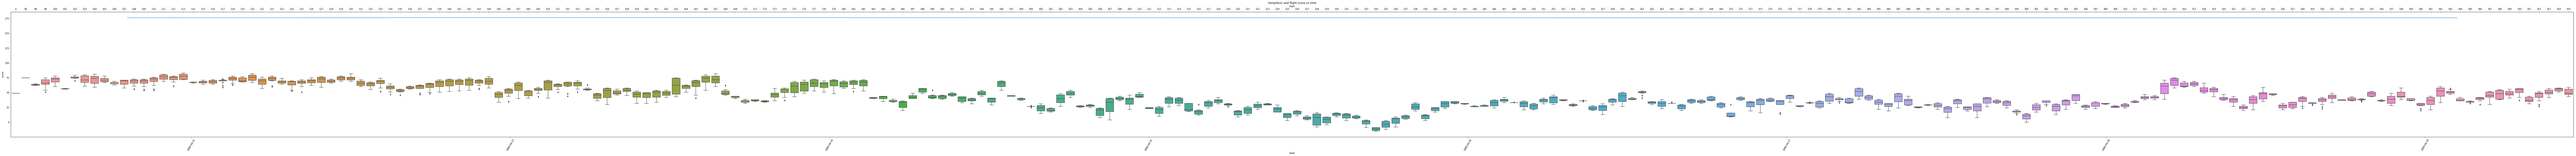

In [29]:
draw_by_feature('temp')

In [50]:
#temp = result.groupby(result['Date'])

In [53]:
#temp.boxplot()

before the plot
after the plot


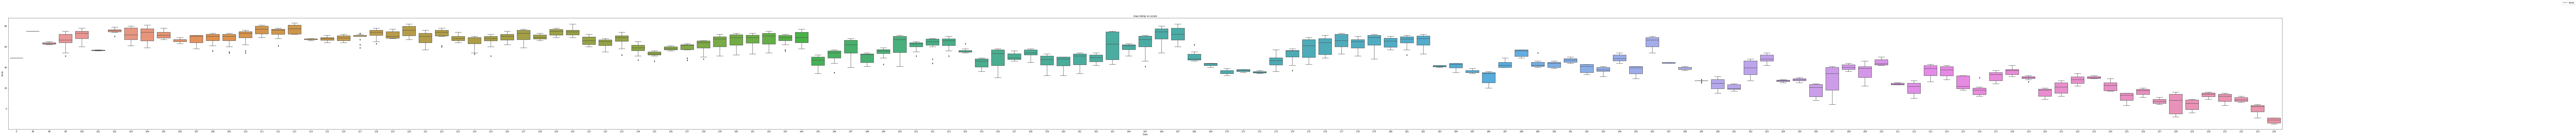

In [17]:
"""
fig = plt.figure(figsize=(200,10))
print('before the plot')
ax1 = sns.boxplot(x="Date", y="temp", data=train_1)
print('after the plot')
fig.legend(labels = ['temp'])
#g.set_xticklabels( date_tick.dt.date.unique(), rotation=60 )
#ax2 = g.twiny()
#ax2=sns.lineplot(x="Date", y="score", data=score_temp)
#ax2.set(ylim=(174,177))
ax1.title.set_text('max temp vs score')
fig.savefig("output.png")

"""

In [ ]:
#fig, ax = plt.subplots( figsize=(200,5) )
#ax.boxplot( pos, train_1.loc, vert=True)
#ax.plot( pos, [ train_1.loc[i].mean() for i in train_1.index ], 'o' )

In [147]:
#score_temp = pd.read_csv('temp_score.csv',dtype={'Date': str, 'score':float})
#score_temp['Date'] = pd.to_datetime(score_temp['Date'], errors = 'coerce')